In [1]:
import os
import pandas as pd
import numpy as np
from numpy.testing import assert_array_equal
import mdtraj as md
import seaborn as sns
from matplotlib import pyplot as plt

dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)
dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)


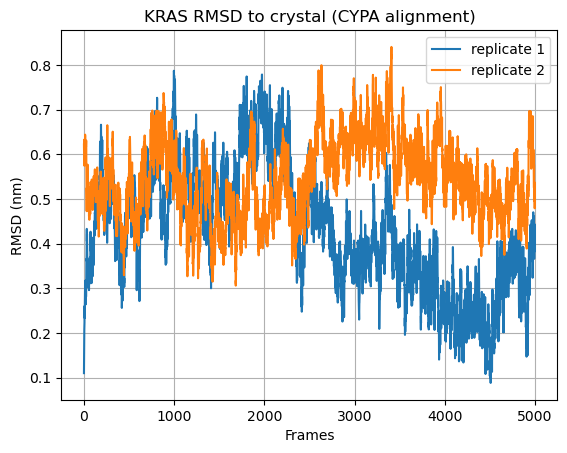

In [9]:
def plot_rmsd_fluctuations_multiple(traj_files, top_file, ref_pdb, plot_type, window, image_molecules=False, title=None):
    rmsd_arrays = []
    labels = []
    ref = md.load_pdb(ref_pdb)
    ref_CYPA_atoms = ref.topology.select('protein and chainid 0 and name CA')
    ref_KRAS_atoms = ref.topology.select('protein and chainid 1 and name CA')

    for i, traj_file in enumerate(traj_files):
        traj = md.load(traj_file, top=top_file)
        if image_molecules:
            traj.image_molecules(inplace=True)
        CYPA_atoms = traj.topology.select('protein and chainid 0 and name CA')
        KRAS_atoms = traj.topology.select('protein and chainid 1 and name CA')
        #
        try:
            assert_array_equal(ref_CYPA_atoms, CYPA_atoms)
            assert_array_equal(ref_KRAS_atoms, KRAS_atoms)
        except AssertionError as e:
            print("Assertion failed for atom indices between trajactory and reference")
        #
        traj.superpose(ref, frame=0, atom_indices=ref_CYPA_atoms)
        traj.save_xtc(f'{i}_processed.xtc')
        #
        result = traj.xyz[:, KRAS_atoms, :] - ref.xyz[0, ref_KRAS_atoms, :]
        ligand_rmsd = np.sqrt((result ** 2).sum(axis=-1).mean(axis=-1))
        n_windows = len(ligand_rmsd) // window
        avg_rmsd = np.array([ligand_rmsd[i*window:(i+1)*window].mean() for i in range(n_windows)])
        avg_frames = np.arange(n_windows) * window
        rmsd_arrays.append(avg_rmsd)
        labels.append(f'replicate {i+1}')
        if plot_type == 'line':
            plt.plot(avg_frames, avg_rmsd, label=labels[-1])
            plt.xlabel('Frames')
            plt.ylabel('RMSD (nm)')
            plt.title(title)
        elif plot_type == 'hist':
            sns.kdeplot(avg_rmsd, label=labels[-1])
            plt.xlabel('RMSD (nm)')
            plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()
    plt.close()
    return rmsd_arrays

forward_sim_rmsd = plot_rmsd_fluctuations_multiple(['long_test_relaxed/crystal_1.dcd', 'long_test_relaxed/cofold_1.dcd'],
                                                   'long_test_relaxed/crystal_min.pdb', 'crystal/crystal.pdb', 'line', 1, image_molecules=True, title = 'KRAS RMSD to crystal (CYPA alignment)')


replicate 1: Mean = -727915.98, Std = 837.82
replicate 2: Mean = -727858.70, Std = 864.14


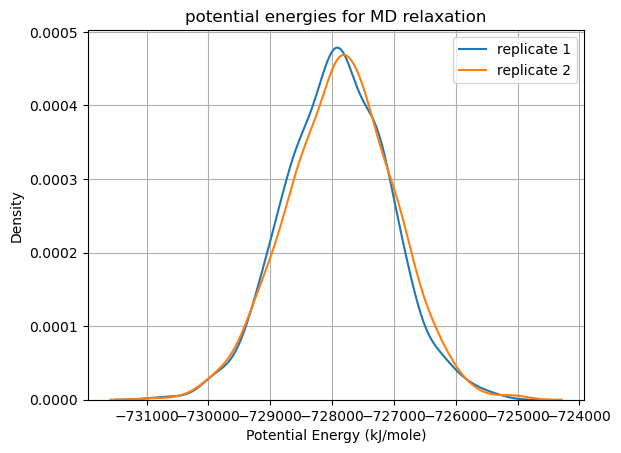

In [11]:
def plot_potential_energy(md_platform, state_file_list, plot_type, window, title):
    energy_arrays = []
    labels = []
    for i, state_file in enumerate(state_file_list):
        if md_platform == 'openmm':
            df = pd.read_csv(state_file)
        elif md_platform == 'gromacs':
            csv_file = os.path.splitext(state_file)[0] + '.csv'
            with open(state_file, 'r') as fin, open(csv_file, 'w') as fout:
                for line in fin:
                    if not (line.startswith('@') or line.startswith('#')):
                        fout.write(','.join(line.split()) + '\n')
            #df = pd.read_csv(csv_file, header=None) #ignore the first row as initial state
            df = pd.read_csv(csv_file)
            df.columns = ['time', 'Potential Energy (kJ/mole)']
        energy = df['Potential Energy (kJ/mole)'][-1000:].to_numpy()
        n_windows = len(energy) // window
        avg_energy = np.array([energy[i*window:(i+1)*window].mean() for i in range(n_windows)])
        avg_frames = np.arange(n_windows) * window
        energy_arrays.append(avg_energy)
        labels.append(f'replicate {i+1}')
        #labels = ['300K NPT', '400K NPT', '500K NPT']
        if plot_type == 'line':
            #plt.plot(avg_frames, avg_energy, label=labels[-1])
            plt.plot(avg_frames, avg_energy, label=labels[i])
            plt.xlabel('Frames')
            plt.ylabel('Potential Energy (kJ/mole)')
            plt.title(f'Potential Energy Over Time (Window = {window} frames)')
            #plt.ylim(np.mean(energy) - 5*np.std(energy), np.mean(energy) + 5*np.std(energy))
            print(f'{labels[i]}: Mean = {np.mean(avg_energy):.2f}, Std = {np.std(avg_energy):.2f}')
        elif plot_type == 'hist':
            #sns.kdeplot(avg_energy, label=labels[-1])
            sns.kdeplot(avg_energy, label=labels[i])
            plt.xlabel('Potential Energy (kJ/mole)')
            plt.title(title)
            #plt.xlim(np.mean(energy) - 5*np.std(energy), np.mean(energy) + 5*np.std(energy))
            print(f'{labels[i]}: Mean = {np.mean(avg_energy):.2f}, Std = {np.std(avg_energy):.2f}')
    plt.grid(True)
    plt.legend()
    plt.show()
    plt.close()

plot_potential_energy('openmm', ['long_test_relaxed/crystal_1.csv', 'long_test_relaxed/cofold_1.csv'], 'hist', 1, 'potential energies for MD relaxation')